In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2021-05-28 14:51:21--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.77MB/s    in 0.8s    

2021-05-28 14:51:22 (5.77 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
data = pd.read_csv("ml-100k/u1.base", sep='\t',names="userId,movieId,rating,timestamp".split(",")) 
u1_data = data.copy()
u1_data

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [38]:
user_list = u1_data['userId']
user_list = user_list.unique()
test_novelty = pd.DataFrame(user_list, columns = ["userId"])

movie_rated_by_user = u1_data.groupby('movieId')['userId'].count().reset_index(name='userIdCount')
movie_rated_by_user = movie_rated_by_user.set_index('movieId')
index_list = movie_rated_by_user.index.tolist()

def find_missing(lst):
    max_num = max(lst)
    min_num = min(lst)
    num_range = range(min_num, max_num+1)
    missing_number = list(set(num_range) - set(lst))
     
    return missing_number

what = find_missing(index_list)
for i in what:
  movie_rated_by_user.loc[i] = [1]
movie_rated_by_user.sort_index()

,userIdCount
movieId,
1,383
2,105
3,75
4,171
5,69
...,...
1678,1
1679,1
1680,1


In [4]:
user_ids = u1_data["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
print('This is user-to-encodeduser')
print(list(user2user_encoded.items())[:10])

userencoded2user = {i: x for i, x in enumerate(user_ids)}
print('This is encodeduser-to-user')
print(list(userencoded2user.items())[:10])

This is user-to-encodeduser
[(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9)]
This is encodeduser-to-user
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]


In [5]:
movie_ids = np.arange(1, 1683)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('This is encodedmovie-to-movie')
print(list(movie2movie_encoded.items())[:10])

movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
print('This is movie-to-encodedmovie')
print(list(movie_encoded2movie.items())[:10])

This is encodedmovie-to-movie
[(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9)]
This is movie-to-encodedmovie
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]


In [6]:
u1_data["user"] = u1_data["userId"].map(user2user_encoded)
u1_data["movie"] = u1_data["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
u1_data["rating"] = u1_data["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later

min_rating = min(u1_data["rating"])
max_rating = max(u1_data["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1682, Min rating: 1.0, Max rating: 5.0


In [7]:
x = u1_data[["user", "movie"]].values
x

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [ 942, 1187],
       [ 942, 1227],
       [ 942, 1329]])

In [8]:
# Normalize the targets between 0 and 1. Makes it easy to train.
y = u1_data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([1.  , 0.5 , 0.75, ..., 0.5 , 0.5 , 0.5 ])

In [9]:
test = pd.read_csv("ml-100k/u1.test", sep='\t',names="userId,movieId,rating,timestamp".split(","))
test

,userId,movieId,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [10]:
test["user"] = test["userId"].map(user2user_encoded)
test["movie"] = test["movieId"].map(movie2movie_encoded)
test

,userId,movieId,rating,timestamp,user,movie
0,1,6,5,887431973,0,5
1,1,10,3,875693118,0,9
2,1,12,5,878542960,0,11
3,1,14,5,874965706,0,13
4,1,17,3,875073198,0,16
...,...,...,...,...,...,...
19995,458,648,4,886395899,457,647
19996,458,1101,4,886397931,457,1100
19997,459,934,3,879563639,458,933
19998,460,10,3,882912371,459,9


In [39]:
# Filter out the rating below 3 as we consider high rated items are those rating equal or above 3
indexNames = test[test['rating'] < 3 ].index
 
# Delete these row indexes from dataFrame
high_test = test.copy().drop(indexNames)
test_precision = high_test.copy().groupby('userId')['movieId'].agg(actual = lambda x: list(set(x)))
test_precision

,actual
userId,
1,"[6, 10, 12, 14, 17, 20, 23, 24, 31, 33, 39, 44..."
2,"[257, 13, 19, 279, 280, 281, 290, 292, 297, 29..."
3,"[350, 354, 327, 328, 299, 331, 334, 307, 343, ..."
4,"[288, 354, 260, 356, 294, 357, 264, 361, 303, 50]"
5,"[384, 1, 2, 385, 391, 139, 267, 143, 144, 17, ..."
...,...
457,"[192, 704, 708, 775, 366, 182, 443, 636]"
458,"[144, 1101, 648]"
459,[934]


In [11]:
x_test = test[["user", "movie"]].values
y_test = test["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [12]:
x_train = x
x_val =  x_test
y_train =  y
y_val = y_test

In [13]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1250/1250 [==============================] - 6s 3ms/step - loss: 0.6547 - val_loss: 0.6357
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6304 - val_loss: 0.6276
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6216 - val_loss: 0.6244
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6191 - val_loss: 0.6257
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6179 - val_loss: 0.6228
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6176 - val_loss: 0.6223
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6156 - val_loss: 0.6216
Epoch 8/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6174 - val_loss: 0.6202
Epoch 9/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6170 - val_loss: 0.6227
Epoch 10/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.617

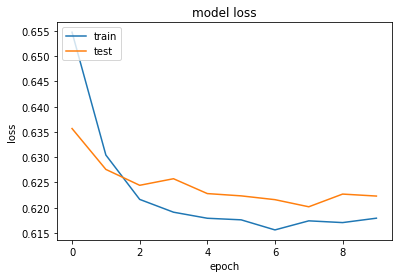

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [17]:
item_column_name = "movieId,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western"
item = pd.read_csv("ml-100k/u.item",sep='|',names=item_column_name.split(","),encoding='latin-1')
item['movieId'] = item['movieId'].map(movie2movie_encoded)
col_to_removed = ['movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
clear_item = item.drop(col_to_removed, axis=1).set_index('movieId')

# the number of the kinds of topics in the whole recommendation system.
N = len(clear_item.columns)

# sum up the genre for each movieId
genre_num = clear_item.sum(axis = 1)

# group table by index and creates a dict with lists of clear_item as values
df_dict = dict(list(clear_item.groupby(clear_item.index)))

# Gather all the genres that related to all movies respectively
movieid = []
genre_list = []

for u, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    if len(check) > 0:
      movieid.append(u)
      genre_list.append(check.to_list())

d = {'movieId' : movieid, 'Genres' : genre_list}

# compile in DataFrame
genre_list_by_movieid = pd.DataFrame(d)
genre_list_by_movieid.set_index('movieId', inplace=True)
genre_list_by_movieid

,Genres
movieId,
0,"[Animation, Children, Comedy]"
1,"[Action, Adventure, Thriller]"
2,[Thriller]
3,"[Action, Comedy, Drama]"
4,"[Crime, Drama, Thriller]"
...,...
1677,[Drama]
1678,"[Romance, Thriller]"
1679,"[Drama, Romance]"


In [19]:
item

,movieId,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
def get_recommendation(user_id):
  movies_watched_by_user = u1_data[u1_data.userId == user_id]
  movies_not_watched = item[~item["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
  movieslist_not_watched = list(
      set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
  )

  movies_not_watched = [[movie2movie_encoded.get(x)] for x in movieslist_not_watched]
  user_encoder = user2user_encoded.get(user_id)
  user_movie_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
  )
  ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movie_ids = [
      movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
  ]

  recommended_movies = item[item["movieId"].isin(recommended_movie_ids)].movieId
  
  return recommended_movies.tolist()

In [36]:
cc  = get_recommendation(user_id)
cc

[12, 114, 134, 169, 178, 318, 408, 480, 483, 603]

In [34]:
cc.movieId.tolist()

[12, 114, 134, 169, 178, 318, 408, 480, 483, 603]

In [ ]:
"""
Precision computation
"""

def precision_per_user(user):
  # get the actual data
  check_a = test_precision.loc[user]
  # check intersect item
  result = float(len(np.intersect1d(check_a['actual'],check_a['predictions'])))

  # user set in test set
  U = 1.00
  # length of recommendation list
  L = min(len(check_a['actual']), len(check_a['predictions']))

  
  precision = (1.0 / U) * (result/L)

  return precision

"""
Novelty computation
"""

def novelty_per_user(user):

  M = unique_user
  L = 10
  sum_novelty = 0
  movie_list = test_precision['predictions'].loc[user]
  for u in movie_list:
    rate_number = movie_rated_by_user.loc[u]
    if (int(rate_number) == 0):
      sum_novelty += 0
    else:
      sum_novelty += math.log2(M/rate_number)

  novelty = sum_novelty/len(movie_list)
  return novelty

"""
Diversity computation
"""

# this function is to check how many genre (topics) included in the movie item
def check_genre_num(movieid):
  n_genre = genre_num.loc[movieid]
  return n_genre

# this function is to get the list of genre that included in the movieId
def check_genre_list(movieid):
  movie_genres = genre_list_by_movieid['Genres'].loc[movieid]
  return movie_genres

# get the movie list per user and return the total genres for that list, z_Lu
def total_genre_per_list(user_movies_list):
  
  total_num_list = []
  
  for n in user_movies_list:
      genre = check_genre_list(n)
      for g in genre:
        total_num_list.append(g)
  
  return total_num_list, len(total_num_list)

# get the movie list per user and return the unique genres for that list, S_Lu
def get_unique_genre_list_by_user(user_movies_list):

  total_list = []
  
  for h in user_movies_list:
    g = check_genre_list(h)
    for k in g:
      total_list.append(k)
  
  unique_list = list(set(total_list))

  return unique_list, len(unique_list)

def H_lu(lu):
  slu, n_slu = get_unique_genre_list_by_user(lu)
  zlu, n_zlu = total_genre_per_list(lu)
  H_lu = 0
  # need to find how many times that topic j is appear in Z_Lu list
  for j in slu:
    count_appear = zlu.count(j)
    qj = count_appear/n_zlu
    H_lu += qj * math.log2(qj)

  return -H_lu

def Div_lu(Lu):
  sl , SLu = get_unique_genre_list_by_user(Lu)
  Nt = N
  hlu = H_lu(Lu)
  Div_lu = (SLu / Nt) * hlu

  return Div_lu

# get the userId list in prediction result
def diversity_per_user(user):
  value1 = 0
  dot_part = 0
  movie_list = test_precision['predictions'].loc[user]

  # total number of topics in recommendation list per user
  zlu, n_zlu = total_genre_per_list(movie_list)

  for item in movie_list:
    txi = check_genre_num(item)
    value1 = txi/n_zlu
    value2 = math.log2(txi/n_zlu)
    dot_part += np.dot(value1,value2)
  diversity_lu = -(dot_part) * Div_lu(movie_list)

  return diversity_lu

def d2(user):
  value1 = 0
  dot_part = 0
  movie_list = test_precision['predictions'].loc[user]

  # total number of topics in recommendation list per user
  zlu, n_zlu = total_genre_per_list(movie_list)

  for item in movie_list:
    txi = check_genre_num(item)
    value1 = txi/n_zlu
    value2 = math.log10(txi/n_zlu)
    dot_part += np.dot(value1,value2)
  diversity2 = -(dot_part) * Div_lu(movie_list)

  return diversity2

In [ ]:
all_avg_precision = []
all_avg_novelty = []
all_avg_diversity = []

recs = []

print('Prediction start....')
pred_start_time = time.time()

for i in test.index:
  test_u = test_ww.iloc[i:i+1,1:]
  userid = test_ww.userId.iloc[i]
  predictions = get_users_predictions(test_u, 10) #len(test_precision.actual.loc[user])
  recs.append(predictions)

execute_duration = time.time() - pred_start_time
print('Done prediction for all users....')
print("\n--- %s seconds ---" % execute_duration)
print()
print('Average duration for each user....')
print("\n--- %s seconds ---" % (execute_duration/943))
print()

test_precision['predictions'] = recs
loss = []
precision = []
novelty = []
diversity = []
diversity2 = []

for ul in test_precision.index:
  precision.append(precision_per_user(ul))
  # p = np.mean(precision)
  # r_precision = 1/(0.05 + np.exp(-p))

  novelty.append(novelty_per_user(ul))
  # n = np.mean(novelty)
  # r_novelty = 1 - n

  diversity.append(diversity_per_user(ul))
  diversity2.append(d2(ul))
  # d = np.mean(diversity)
  # r_diversity = 1/(0.05 + np.exp(-d))

# all_avg_precision.append(p)
# all_avg_novelty.append(n)
# all_avg_diversity.append(d)
# reward_precision.append(r_precision)
# reward_novelty.append(r_novelty)
# reward_diversity.append(r_diversity)

print("---------Precision-------")
print("Precision max: ", max(precision))
print("Precision min: ", min(precision))
print("Precision mean: ", np.mean(precision))
print()

print("---------Novelty-------")
print("Novelty max: ", max(novelty))
print("Novelty min: ", min(novelty))
print("Novelty mean: ", np.mean(novelty))
print()

print("---------Diversity-------")
print("Diversity max: ", max(diversity))
print("Diversity min: ", min(diversity))
print("Diversity mean: ", np.mean(diversity))
print()

print("---------D2-------")
print("Diversity max: ", max(diversity2))
print("Diversity min: ", min(diversity2))
print("Diversity mean: ", np.mean(diversity2))